In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashion-product-images-small/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/images/31973.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/30778.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/19812.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/22735.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/38246.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/16916.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/52876.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/39500.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44758.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/59454.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44951.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/

In [2]:
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar
import random
import requests
from io import BytesIO

In [3]:
# Parameters
data_dir = '/kaggle/input/fashion-product-images-small/images'
img_size = 128

In [4]:
df = pd.read_csv("/kaggle/input/fashion-product-images-small/styles.csv", on_bad_lines='skip')
df = df[:10000]
df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [5]:
# Assuming 'data_dir' and 'img_size' are defined earlier
list_of_data = []
total_processed = 0
total_skipped = 0

# Use tqdm to wrap around df.iterrows() for progress tracking
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images"):
    img_path = os.path.join(data_dir, str(row['id']) + ".jpg")

    # Check if the image file exists before trying to read it
    if not os.path.exists(img_path):
        print(f"Warning: Image file not found at path: {img_path}")
        total_skipped += 1  # Increment skipped counter for missing file
        continue  # Skip to the next iteration if the image is not found

    # Check for missing class labels
    if any(row.get(key) is None for key in ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']):
        print(f"Skipping image due to missing class labels for ID: {row['id']}")
        total_skipped += 1  # Increment skipped counter for missing class labels
        continue  # Skip to the next iteration if any class label is missing

    img_arr = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshape images to preferred size

    json_dict = {
        'image': resized_arr.tolist(),  # Convert NumPy array to list for JSON serialization
        'class_1': row['gender'],
        'class_2': row['masterCategory'],
        'class_3': row['subCategory'],
        'class_4': row['articleType'],
        'class_5': row['baseColour'],
        'class_6': row['season'],
        'class_7': row['usage']
    }

    # Append the json_dict to the list
    list_of_data.append(json_dict)
    total_processed += 1  # Increment processed counter

# Print the summary
print(f"Total images processed: {total_processed}")
print(f"Total images skipped: {total_skipped}")

Processing Images:  67%|██████▋   | 6706/10000 [02:09<00:35, 92.47it/s]

Processing Images: 100%|██████████| 10000/10000 [03:13<00:00, 51.59it/s]


Total images processed: 9999
Total images skipped: 1


In [6]:
# Splitting into x_train and y_train
x_train = []
y_train = []

for data in list_of_data:
    x_train.append(data['image'])
    y_train.append([data['class_1'], data['class_2'], data['class_3'], data['class_4'], data['class_5'], data['class_6'], data['class_7']])

x_train = np.array(x_train) / 255
x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 3)

In [7]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(x_train)

In [8]:
y_train = np.array(y_train)

# Initialize lists to store mappings and class arrays
class_maps = {}
class_arrays = []
num_classes = 7  # Update this if you have more or fewer classes

# Loop through each class
for i in range(num_classes):
    class_data = y_train[:, i]  # Get data for the current class
    class_map = {j: idx for idx, j in enumerate(set(class_data))}
    class_arr = np.array([class_map[x] for x in class_data])
    
    class_maps[f'map_{i + 1}'] = class_map  # Store the mapping
    class_arrays.append(class_arr)  # Append the class array to the list

# Convert class_arrays list to a 2D NumPy array if needed
class_arrays = np.array(class_arrays).T  # Transpose to get the correct shape
# Assuming you have already determined the number of classes for each task
c_1 = len(class_maps['map_1'])  # Number of classes for gender
c_2 = len(class_maps['map_2'])  # Number of classes for master category
c_3 = len(class_maps['map_3'])  # Number of classes for sub-category
c_4 = len(class_maps['map_4'])  # Number of classes for article type
c_5 = len(class_maps['map_5'])  # Number of classes for base color
c_6 = len(class_maps['map_6'])  # Number of classes for season
c_7 = len(class_maps['map_7'])  # Number of classes for usage
class_arr_gender = class_arrays[:, 0]  # Adjust the index based on your arrangement
class_arr_master_category = class_arrays[:, 1]
class_arr_sub_category = class_arrays[:, 2]
class_arr_article_type = class_arrays[:, 3]
class_arr_base_colour = class_arrays[:, 4]
class_arr_season = class_arrays[:, 5]
class_arr_usage = class_arrays[:, 6]

In [18]:
# Input layer
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Base CNN Layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Output branches for multitask classification
gender_branch = tf.keras.layers.Dense(c_1, activation='softmax', name='gender_output')(x)
master_category_branch = tf.keras.layers.Dense(c_2, activation='softmax', name='masterCategory_output')(x)
sub_category_branch = tf.keras.layers.Dense(c_3, activation='softmax', name='subCategory_output')(x)
article_type_branch = tf.keras.layers.Dense(c_4, activation='softmax', name='articleType_output')(x)
base_colour_branch = tf.keras.layers.Dense(c_5, activation='softmax', name='baseColour_output')(x)
season_branch = tf.keras.layers.Dense(c_6, activation='softmax', name='season_output')(x)
usage_branch = tf.keras.layers.Dense(c_7, activation='softmax', name='usage_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[
    gender_branch,
    master_category_branch,
    sub_category_branch,
    article_type_branch,
    base_colour_branch,
    season_branch,
    usage_branch
])

# Summary of the model to check the architecture
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        896 │ main_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │ 16,777,728 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 5)         │      2,565 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masterCategory_out… │ (None, 6)         │      3,078 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subCategory_output  │ (None, 40)        │     20,520 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ articleType_output  │ (None, 127)       │     65,151 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseColour_output   │ (None, 46)        │     23,598 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_output       │ (None, 5)         │      2,565 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ usage_output        │ (None, 8)         │      4,104 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,992,557 (64.82 MB)

 Trainable params: 16,992,557 (64.82 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss={
        'gender_output': 'sparse_categorical_crossentropy',
        'masterCategory_output': 'sparse_categorical_crossentropy',
        'subCategory_output': 'sparse_categorical_crossentropy',
        'articleType_output': 'sparse_categorical_crossentropy',
        'baseColour_output': 'sparse_categorical_crossentropy',
        'season_output': 'sparse_categorical_crossentropy',
        'usage_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'gender_output': 1.0,
        'masterCategory_output': 1.0,
        'subCategory_output': 1.0,
        'articleType_output': 1.0,
        'baseColour_output': 1.0,
        'season_output': 1.0,
        'usage_output': 1.0
    },
    metrics={
        'gender_output': ['accuracy'],
        'masterCategory_output': ['accuracy'],
        'subCategory_output': ['accuracy'],
        'articleType_output': ['accuracy'],
        'baseColour_output': ['accuracy'],
        'season_output': ['accuracy'],
        'usage_output': ['accuracy']
    }
)


In [20]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'gender_output': class_arr_gender,  # Assuming you have a corresponding class array
        'masterCategory_output': class_arr_master_category,
        'subCategory_output': class_arr_sub_category,
        'articleType_output': class_arr_article_type,
        'baseColour_output': class_arr_base_colour,
        'season_output': class_arr_season,
        'usage_output': class_arr_usage
    },
    epochs=10,
    batch_size=128,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - articleType_output_accuracy: 0.1691 - baseColour_output_accuracy: 0.2027 - gender_output_accuracy: 0.4742 - loss: 18.3933 - masterCategory_output_accuracy: 0.5469 - season_output_accuracy: 0.3791 - subCategory_output_accuracy: 0.3594 - usage_output_accuracy: 0.7174 - val_articleType_output_accuracy: 0.4310 - val_baseColour_output_accuracy: 0.3785 - val_gender_output_accuracy: 0.6215 - val_loss: 9.0670 - val_masterCategory_output_accuracy: 0.8820 - val_season_output_accuracy: 0.5480 - val_subCategory_output_accuracy: 0.7255 - val_usage_output_accuracy: 0.7780
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - articleType_output_accuracy: 0.5003 - baseColour_output_accuracy: 0.3839 - gender_output_accuracy: 0.7259 - loss: 8.0439 - masterCategory_output_accuracy: 0.8995 - season_output_accuracy: 0.5300 - subCategory_output_accuracy: 0.7501 - usage_output_accuracy: 0.8097 - val_articleType_output_accuracy: 0.5755 - val_baseColour_out

In [21]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv('training_history.csv', index=False)

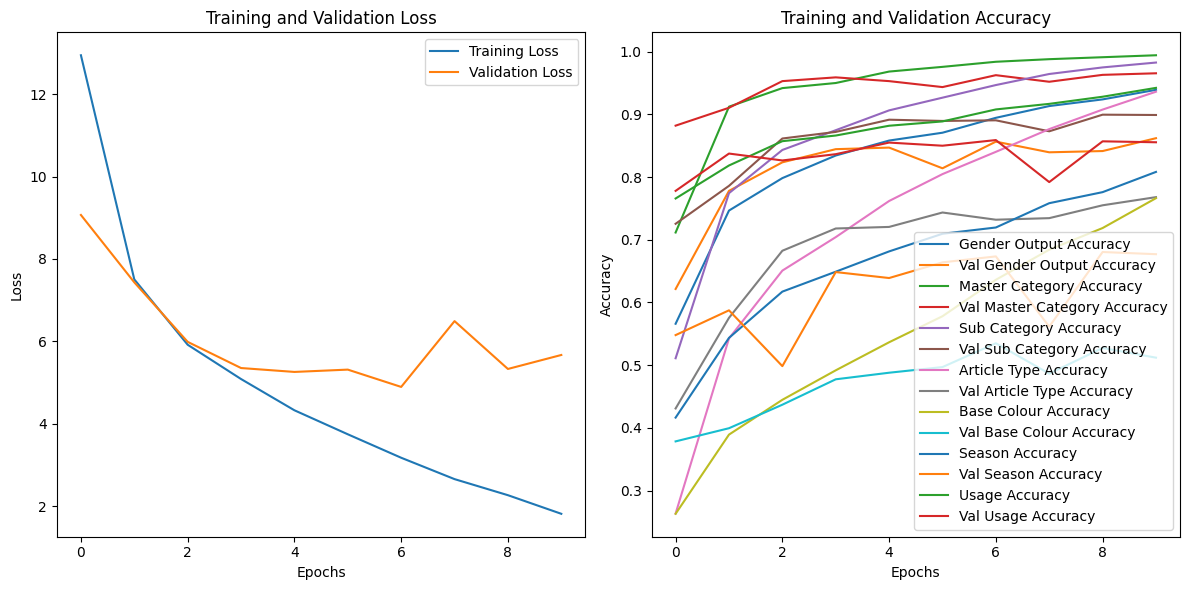

In [22]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Gender Output Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Output Accuracy')

plt.plot(history.history['masterCategory_output_accuracy'], label='Master Category Accuracy')
plt.plot(history.history['val_masterCategory_output_accuracy'], label='Val Master Category Accuracy')

plt.plot(history.history['subCategory_output_accuracy'], label='Sub Category Accuracy')
plt.plot(history.history['val_subCategory_output_accuracy'], label='Val Sub Category Accuracy')

plt.plot(history.history['articleType_output_accuracy'], label='Article Type Accuracy')
plt.plot(history.history['val_articleType_output_accuracy'], label='Val Article Type Accuracy')

plt.plot(history.history['baseColour_output_accuracy'], label='Base Colour Accuracy')
plt.plot(history.history['val_baseColour_output_accuracy'], label='Val Base Colour Accuracy')

plt.plot(history.history['season_output_accuracy'], label='Season Accuracy')
plt.plot(history.history['val_season_output_accuracy'], label='Val Season Accuracy')

plt.plot(history.history['usage_output_accuracy'], label='Usage Accuracy')
plt.plot(history.history['val_usage_output_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

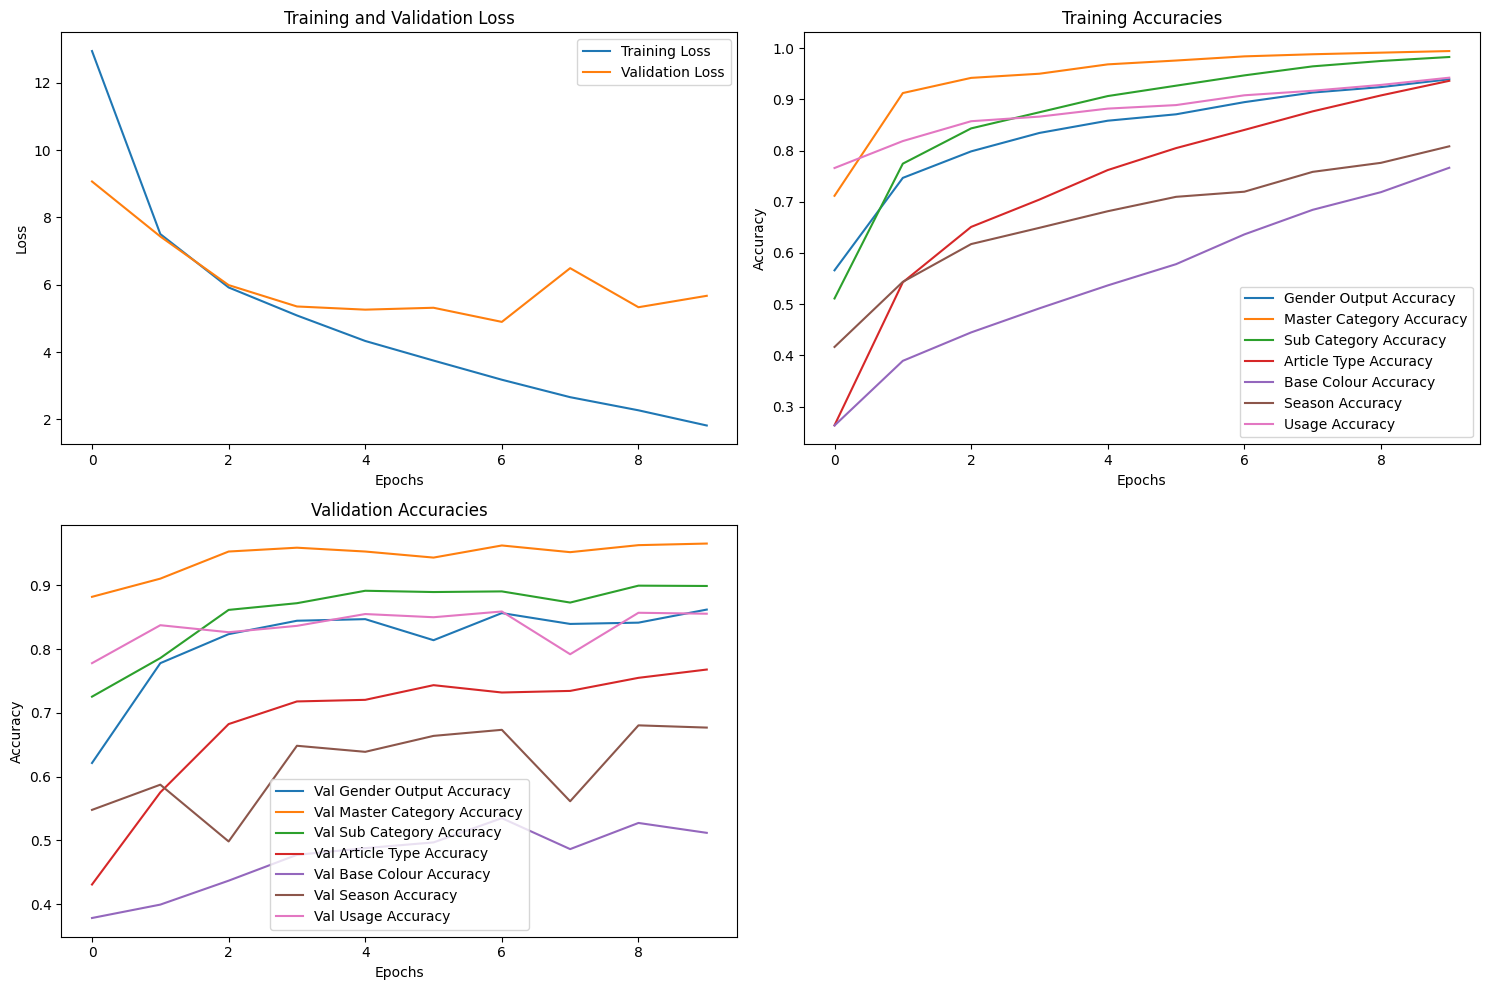

In [23]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Gender Output Accuracy')
plt.plot(history.history['masterCategory_output_accuracy'], label='Master Category Accuracy')
plt.plot(history.history['subCategory_output_accuracy'], label='Sub Category Accuracy')
plt.plot(history.history['articleType_output_accuracy'], label='Article Type Accuracy')
plt.plot(history.history['baseColour_output_accuracy'], label='Base Colour Accuracy')
plt.plot(history.history['season_output_accuracy'], label='Season Accuracy')
plt.plot(history.history['usage_output_accuracy'], label='Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Output Accuracy')
plt.plot(history.history['val_masterCategory_output_accuracy'], label='Val Master Category Accuracy')
plt.plot(history.history['val_subCategory_output_accuracy'], label='Val Sub Category Accuracy')
plt.plot(history.history['val_articleType_output_accuracy'], label='Val Article Type Accuracy')
plt.plot(history.history['val_baseColour_output_accuracy'], label='Val Base Colour Accuracy')
plt.plot(history.history['val_season_output_accuracy'], label='Val Season Accuracy')
plt.plot(history.history['val_usage_output_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [24]:
# Extract the accuracy values for each output
val_gender_accuracy = history.history['val_gender_output_accuracy']
val_master_category_accuracy = history.history['val_masterCategory_output_accuracy']
val_sub_category_accuracy = history.history['val_subCategory_output_accuracy']
val_article_type_accuracy = history.history['val_articleType_output_accuracy']
val_base_colour_accuracy = history.history['val_baseColour_output_accuracy']
val_season_accuracy = history.history['val_season_output_accuracy']
val_usage_accuracy = history.history['val_usage_output_accuracy']

# Print the final accuracies
print("Final Validation Accuracies:")
print(f"Gender Output Accuracy: {val_gender_accuracy[-1]:.4f}")
print(f"Master Category Accuracy: {val_master_category_accuracy[-1]:.4f}")
print(f"Sub Category Accuracy: {val_sub_category_accuracy[-1]:.4f}")
print(f"Article Type Accuracy: {val_article_type_accuracy[-1]:.4f}")
print(f"Base Colour Accuracy: {val_base_colour_accuracy[-1]:.4f}")
print(f"Season Accuracy: {val_season_accuracy[-1]:.4f}")
print(f"Usage Accuracy: {val_usage_accuracy[-1]:.4f}")

Final Validation Accuracies:
Gender Output Accuracy: 0.8620
Master Category Accuracy: 0.9655
Sub Category Accuracy: 0.8990
Article Type Accuracy: 0.7680
Base Colour Accuracy: 0.5120
Season Accuracy: 0.6770
Usage Accuracy: 0.8555


In [16]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    if image_path.startswith('http://') or image_path.startswith('https://'):
        # If the input is a URL, download the image
        response = requests.get(image_path)
        img = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    else:
        # Otherwise, read the image from the local file system
        img = cv2.imread(image_path)[..., ::-1]  # Read image and convert BGR to RGB

    img_resized = cv2.resize(img, (img_size, img_size))  # Resize to the expected input size
    img_array = np.array(img_resized) / 255.0  # Normalize the image
    img_array = img_array.reshape(1, img_size, img_size, 3)  # Add batch dimension
    return img_array

def get_model_predictions(image_path):
    # Load and preprocess the random image
    input_image = load_and_preprocess_image(image_path)

    # Make predictions using the trained model
    predictions = model.predict(input_image)

    # Display the image
    plt.imshow(input_image[0])  # Display the image (remove batch dimension)
    plt.axis('off')  # Hide axis
    plt.show()

    # Prepare to decode predictions
    for i, class_output in enumerate(predictions):
        class_map = class_maps[f'map_{i + 1}']  # Get the mapping for the current class
        predicted_class_index = np.argmax(class_output)  # Get the index of the highest probability
        predicted_class = list(class_map.keys())[list(class_map.values()).index(predicted_class_index)]  # Map index back to class label
        print(f"Prediction for class {i + 1} ({['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage'][i]}): {predicted_class}")

# Example usage with a random image from the dataset or a URL
random_index = random.randint(0, len(df) - 1)
random_image_id = df.iloc[random_index]['id']
random_image_path = os.path.join(data_dir, f"{random_image_id}.jpg")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


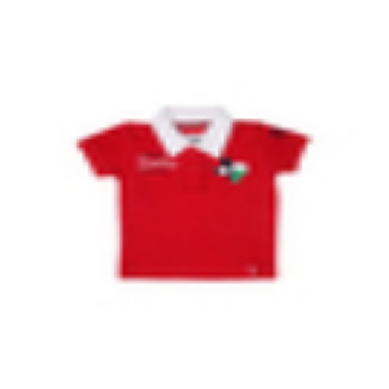

Prediction for class 1 (gender): Boys
Prediction for class 2 (masterCategory): Apparel
Prediction for class 3 (subCategory): Topwear
Prediction for class 4 (articleType): Tshirts
Prediction for class 5 (baseColour): Red
Prediction for class 6 (season): Summer
Prediction for class 7 (usage): Casual


In [29]:
# Select a random image from the dataset
random_index = random.randint(0, len(df) - 1)
random_image_id = df.iloc[random_index]['id']
random_image_path = os.path.join(data_dir, f"{random_image_id}.jpg")
get_model_predictions(random_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


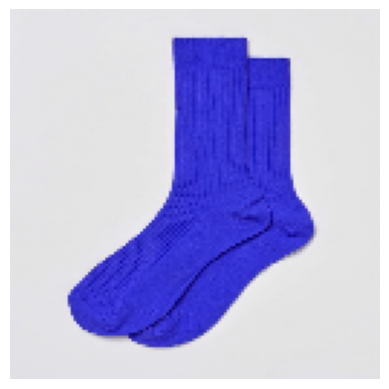

Prediction for class 1 (gender): Women
Prediction for class 2 (masterCategory): Apparel
Prediction for class 3 (subCategory): Topwear
Prediction for class 4 (articleType): Shirts
Prediction for class 5 (baseColour): Blue
Prediction for class 6 (season): Fall
Prediction for class 7 (usage): Casual


In [30]:
# Use a URL instead
url_image_path = "https://content.josephturner.co.uk/ExtraLarge/mens-red-classic-ankle-socks-masossred_1.jpg"

# Get predictions for both local and URL images
#get_model_predictions(random_image_path)  # For local image
get_model_predictions(url_image_path)  # Uncomment to use a URL image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


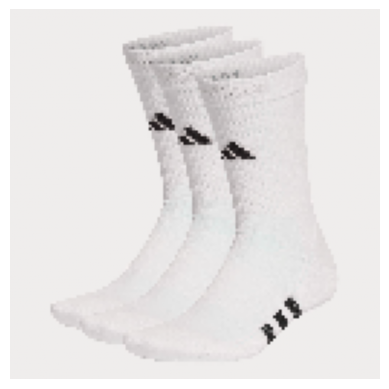

Prediction for class 1 (gender): Men
Prediction for class 2 (masterCategory): Apparel
Prediction for class 3 (subCategory): Dress
Prediction for class 4 (articleType): Tshirts
Prediction for class 5 (baseColour): White
Prediction for class 6 (season): Summer
Prediction for class 7 (usage): Casual


In [31]:
# Use a URL instead
url_image_path = "https://assets.adidas.com/images/w_1880,f_auto,q_auto/3d7c3acb7eb2450d8031af10009c4209_9366/HT3452_03_standard.jpg"

# Get predictions for both local and URL images
#get_model_predictions(random_image_path)  # For local image
get_model_predictions(url_image_path)  # Uncomment to use a URL image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


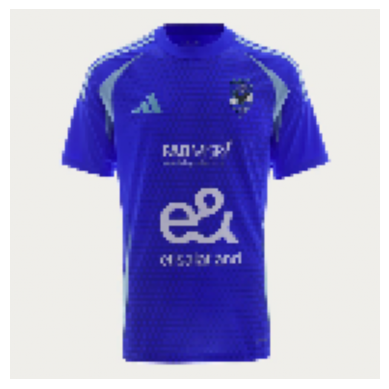

Prediction for class 1 (gender): Women
Prediction for class 2 (masterCategory): Apparel
Prediction for class 3 (subCategory): Topwear
Prediction for class 4 (articleType): Tshirts
Prediction for class 5 (baseColour): Blue
Prediction for class 6 (season): Summer
Prediction for class 7 (usage): Casual


In [33]:
# Use a URL instead
url_image_path = "https://assets.adidas.com/images/w_940,f_auto,q_auto/038692973e594495a5966d3ba81af3b7_9366/JK2250_21_model.jpg"

# Get predictions for both local and URL images
#get_model_predictions(random_image_path)  # For local image
get_model_predictions(url_image_path)  # Uncomment to use a URL image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


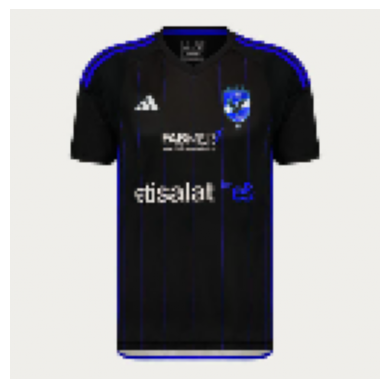

Prediction for class 1 (gender): Women
Prediction for class 2 (masterCategory): Apparel
Prediction for class 3 (subCategory): Topwear
Prediction for class 4 (articleType): Tshirts
Prediction for class 5 (baseColour): Black
Prediction for class 6 (season): Summer
Prediction for class 7 (usage): Casual


In [34]:
# Use a URL instead
url_image_path = "https://assets.adidas.com/images/w_450,f_auto,q_auto/fd0c862cca3c4d1eb970b4c1115e773f_9366/IU7914_01_laydown.jpg"

# Get predictions for both local and URL images
#get_model_predictions(random_image_path)  # For local image
get_model_predictions(url_image_path)  # Uncomment to use a URL image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


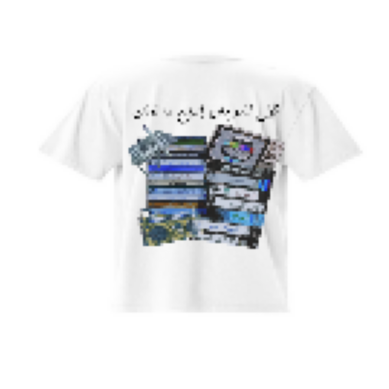

Prediction for class 1 (gender): Girls
Prediction for class 2 (masterCategory): Apparel
Prediction for class 3 (subCategory): Topwear
Prediction for class 4 (articleType): Tshirts
Prediction for class 5 (baseColour): Blue
Prediction for class 6 (season): Summer
Prediction for class 7 (usage): Casual


In [35]:
# Use a URL instead
url_image_path = "https://zaahe.com/wp-content/uploads/2024/05/%D8%A7%D8%AF%D9%8A%D9%85%D9%88-4-600x772.png"

# Get predictions for both local and URL images
#get_model_predictions(random_image_path)  # For local image
get_model_predictions(url_image_path)  # Uncomment to use a URL image